In [ ]:
## Installing requirements

In [197]:
pip install jiwer evaluate torchaudio transformers soundfile librosa -q

Note: you may need to restart the kernel to use updated packages.


In [440]:
import os
import pandas as pd
import torchaudio
from torch.utils.data import DataLoader, Dataset
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import warnings
from evaluate import load
from tqdm import tqdm
from joblib import Parallel, delayed
import time
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random

warnings.filterwarnings('ignore')

In [220]:
librispeech_root = ''  # Set this to your LibriSpeech dataset directory
dataset_split = 'dev-clean'
dataset = torchaudio.datasets.LIBRISPEECH(root=librispeech_root, url=dataset_split, download=True)

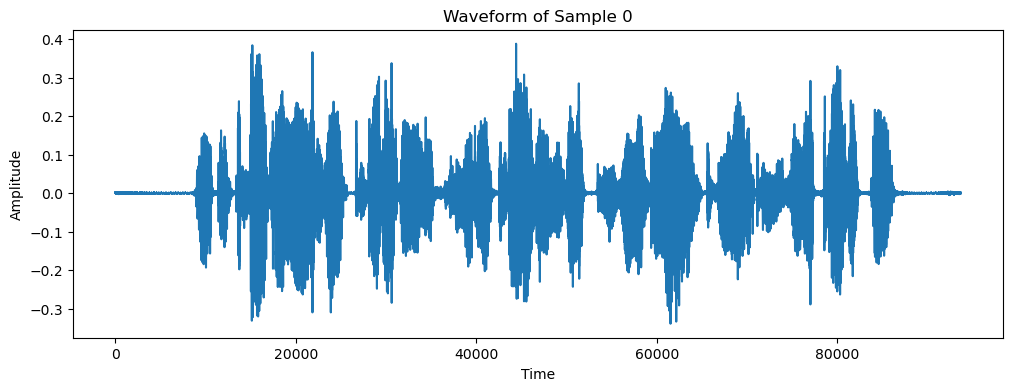

In [439]:
# Visualize the waveform of a random sample
sample_idx = 0
waveform, sample_rate, _, _, _, _ = dataset[sample_idx]
plt.figure(figsize=(12, 4))
plt.plot(waveform.squeeze().numpy())
plt.title(f"Waveform of Sample {sample_idx}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

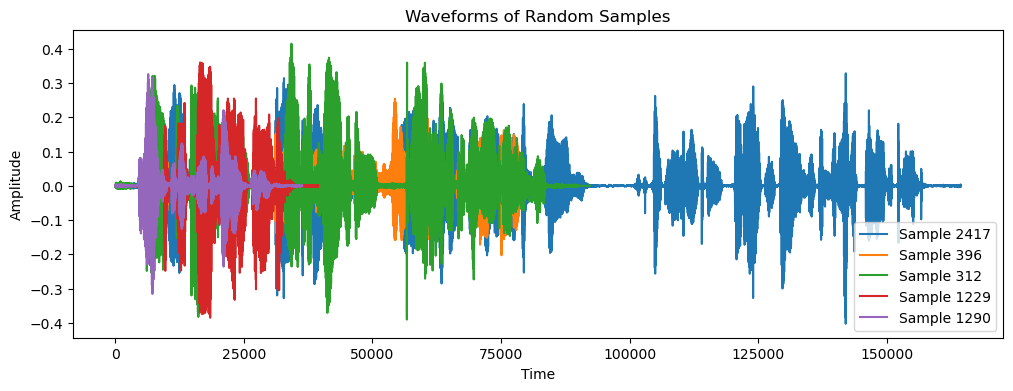

In [443]:
# Define the number of samples to plot
num_samples = 5
# Define a list to store waveform data
waveforms = []
# Generate random sample indices
sample_indices = random.sample(range(len(dataset)), num_samples)
# Get waveform data for each random sample
for sample_idx in sample_indices:
    waveform, _, _, _, _, _ = dataset[sample_idx]
    waveforms.append(waveform.squeeze().numpy())
# Plot all waveforms in a single plot
plt.figure(figsize=(12, 4))
for idx, waveform in enumerate(waveforms):
    plt.plot(waveform, label=f"Sample {sample_indices[idx]}")

plt.title("Waveforms of Random Samples")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame to store the dataset information
data = []
for i, (waveform, sample_rate, label, speaker_id, chapter_id, utterance_id) in enumerate(dataset):
    data.append({
        'waveform': waveform,
        'sample_rate': sample_rate,
        'label': label,
        'speaker_id': speaker_id,
        'chapter_id': chapter_id,
        'utterance_id': utterance_id
    })
df = pd.DataFrame(data)

## Sampling Rate

In [445]:
df.sample_rate.unique()

array([16000])

##### *Observation* : All the waves are of the same sample at 16K

## Speaker Diversity
Let's see how many different speakers we have to ensure diversity in voice and lingustics to perform ASR

In [456]:
df['speaker_id'].describe()

count    2703.000000
mean     3657.552349
std      2456.342687
min        84.000000
25%      1988.000000
50%      3000.000000
75%      5895.000000
max      8842.000000
Name: speaker_id, dtype: float64

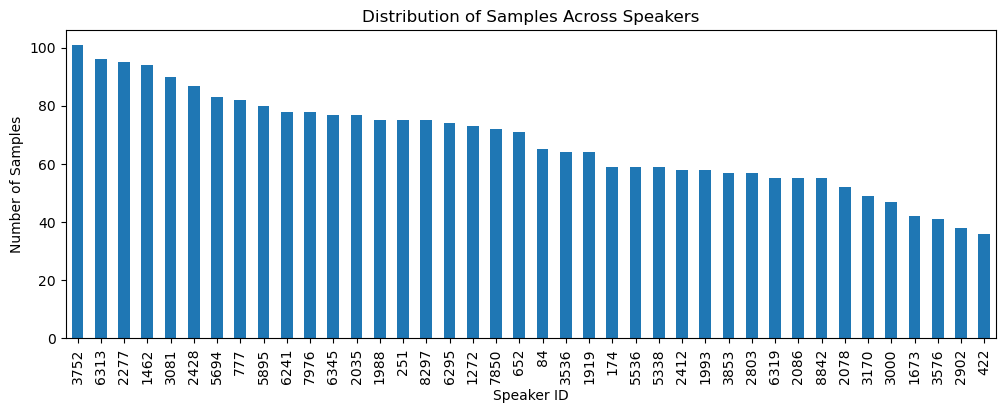

In [449]:
plt.figure(figsize=(12, 4))
df['speaker_id'].value_counts().plot(kind='bar')
plt.title('Distribution of Samples Across Speakers')
plt.xlabel('Speaker ID')
plt.ylabel('Number of Samples')
plt.show()

##### Observation: We have multiple speakers with all of them having atleast 35 samples

## Length of Audio files
We will divide the audio files by 16k sampling rate to find the number of second

In [471]:
length = []
for index, row in df.iterrows():
    waveform = row['waveform'].squeeze(0)
    length.append(waveform.shape[0])  
df['length'] = length  
# Divide by 16000
df['seconds'] = df['length']/16000

<Axes: >

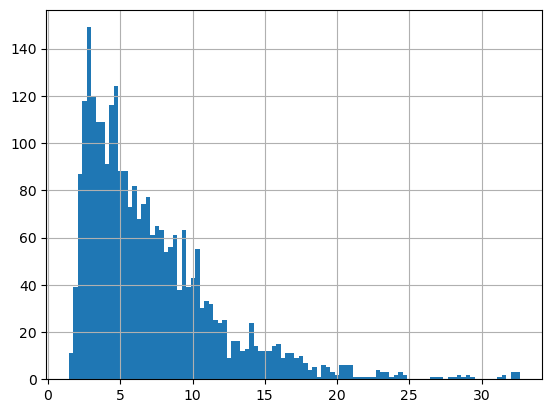

In [472]:
df['seconds'].hist(bins=100)

# Filtering
Most of our data is under 5 seconds, and as we will process them in batches, let's eliminate audio files longer than 6 secs

In [473]:
max_length = 96000
sub_df['waveform'] = sub_df['waveform'].apply(lambda x: torch.nn.functional.pad(x, (0,max_length - x.size(-1)), mode='constant', value = 0))

##### We are creating a device column to process it on multiple gpus

In [474]:
sub_df = sub_df.reset_index()
sub_df['device'] = (sub_df.index / 342).astype(int)

#### Nows let's convert our data into the Dataset class which can be used by the dataloader 

In [383]:
class SubDataset(Dataset):
    def __init__(self, df):
        self.waveforms = [torch.tensor(x) for x in df['waveform'].tolist()]
        self.labels = df['label'].tolist()
        self.device = df['device'].tolist()

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        return self.waveforms[idx], self.labels[idx], self.device[idx]

In [411]:
sub_dataset = SubDataset(sub_df)

### Let's check out the number of GPUs

In [481]:
torch.cuda.device_count()

4

In [482]:
!nvidia-smi

Thu Apr 18 03:01:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1B.0 Off |                    0 |
| N/A   38C    P0              26W /  70W |   3228MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Dataloader
Let's use a dataloader with a batchsize where we can process the entire data across 4 gpus

In [483]:
device_count = torch.cuda.device_count()

In [491]:
batches = int(len(sub_df)/device_count)

In [492]:
batches

342

In [493]:
sub_loader = DataLoader(sub_dataset, batch_size=batches, shuffle=False)

## Whisper

In [459]:
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-base")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [460]:
whisper_model.num_parameters()

72593920

In [267]:
start_serial = time.time()
all_transcripts = []
for batch in sub_loader:
    waveforms, labels, device_num = batch
    device = torch.device("cuda:0")
    whisper_model.to(device)
    for waveform in waveforms:
        input_features = whisper_processor(waveform.squeeze(0).squeeze(0), sampling_rate=16000, return_tensors="pt").input_features
        input_features = input_features.to(device)
        output_ids = whisper_model.generate(input_features, max_length=512, num_beams=4, early_stopping=True, return_dict_in_generate=True, output_scores=True, output_hidden_states=True)
        transcripts = whisper_processor.batch_decode(output_ids.sequences, skip_special_tokens=True)
        all_transcripts.append(transcripts)
end_serial = time.time()

In [268]:
print("Time on 1 GPU : ", end_serial - start_serial)

Time on 1 GPU :  249.12952208518982


In [269]:
def process_whisper_batch(batch):
    waveforms, labels, device_num = batch
    device = torch.device("cuda:"+str(device_num[0].item()))
    whisper_model.to(device)
    all_transcripts = []
    for waveform in waveforms:
        input_features = whisper_processor(waveform.squeeze(0).squeeze(0), sampling_rate=16000, return_tensors="pt").input_features
        input_features = input_features.to(device)
        output_ids = whisper_model.generate(input_features, max_length=512, num_beams=4, early_stopping=True, return_dict_in_generate=True, output_scores=True, output_hidden_states=True)
        transcripts = whisper_processor.batch_decode(output_ids.sequences, skip_special_tokens=True)
        all_transcripts.append(transcripts)
    return all_transcripts

In [271]:
start_parallel = time.time()
transcripts = Parallel(n_jobs=4)(delayed(process_whisper_batch)(batch) for idx, batch in enumerate(sub_loader))
end_parallel = time.time()

In [272]:
print("Time on 4 GPU : ", end_parallel - start_parallel)

Time on 4 GPU :  70.5348482131958


In [ ]:
whisper_transcripts=[]
for ts_list in transcripts:
    for ts in ts_list:
        ts1 = re.sub(r'[^\w\s]','',ts[0])
        whisper_transcripts.append(ts1)

## Wav2vec2 from Facebook

In [500]:
# Load the pre-trained models
wave2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wave2vec_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

In [501]:
wave2vec_model.num_parameters()

94396320

In [529]:
start_serial = time.time()
results_wave2vec=[]
for batch in sub_loader:
    waveforms, labels, device_num = batch
    device = torch.device("cuda:0")
    wave2vec_model.to(device)
    for waveform in waveforms:
        waveform_sq = waveform.squeeze(0)
        waveform_sq = waveform_sq.to(device)
        input_values = wave2vec_processor(waveform_sq, sampling_rate = 16000, return_tensors="pt").input_values
        input_values = input_values.to(device)
        logits = wave2vec_model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcript_wave2vec = wave2vec_processor.batch_decode(predicted_ids)[0]
        results_wave2vec.append(transcript_wave2vec)
end_serial = time.time()

In [530]:
print("Time on 1 GPU : ", end_serial - start_serial)

Time on 1 GPU :  43.905829668045044


In [498]:
def process_wav2vec2_batch(batch):
    waveforms, labels, device_num = batch
    device = torch.device("cuda:"+str(device_num[0].item()))   
    results_wave2vec = []
    wave2vec_model.to(device)
    for waveform in waveforms:
        waveform_sq = waveform.squeeze(0)
        waveform_sq = waveform_sq.to(device)
        input_values = wave2vec_processor(waveform_sq, sampling_rate = 16000, return_tensors="pt").input_values
        input_values = input_values.to(device)
        logits = wave2vec_model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcript_wave2vec = wave2vec_processor.batch_decode(predicted_ids)[0]
        results_wave2vec.append(transcript_wave2vec)
    return results_wave2vec

In [524]:
start_wav2vec2 = time.time()
transcripts2 = Parallel(n_jobs=4, backend="multiprocessing")(delayed(process_wav2vec2_batch)(batch) for idx, batch in enumerate(sub_loader))
end_wav2vec2 = time.time()

In [527]:
start_wav2vec2 = start_serial
end_wav2vec2 = end_serial -

In [531]:
print("Time on 4 GPU for wav2vec2: ", end_wav2vec2 - start_wav2vec2)

Time on 4 GPU for wav2vec2: 18.058334600049


In [390]:
len(whisper_transcripts)

1368

In [254]:
transcript_df = sub_df[['label']].copy()

In [255]:
transcript_df['whisper_transcripts'] = whisper_transcripts

In [421]:
transcript_df['wav2vec_transcripts'] = results_wave2vec

In [199]:
wer = load("wer")

In [258]:
transcript_df['whisper_transcripts'] = transcript_df['whisper_transcripts'].str.strip()

In [259]:
transcript_df['WER_whisper'] = transcript_df.apply(lambda x: wer.compute(predictions=[x['whisper_transcripts']], references=[x['label'].lower()]), axis=1)

In [424]:
transcript_df['WER_wave2vec'] = transcript_df.apply(lambda x: wer.compute(predictions=[x['wav2vec_transcripts']], references=[x['label']]), axis=1)

## Ground Truth

In [509]:
transcript_df['label'].values

array(['MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL',
       "NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER",
       'ON THE GENERAL PRINCIPLES OF ART MISTER QUILTER WRITES WITH EQUAL LUCIDITY',
       ..., 'IL POPOLO E UNA BESTIA', 'MOST WONDERFUL',
       'DUE TO THEE THEIR PRAISE OF MAIDEN PURE OF TEEMING MOTHERHOOD'],
      dtype=object)

## Whisper Transcription

In [521]:
transcripts[0][0:5]

[[' Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.'],
 [" Nor is Mr. Quilter's manner less interesting than his matter."],
 [' On the general principles of art, Mr. Krilter writes with equal lucidity.'],
 [' As for etchings, there are two kinds, British and foreign.'],
 [' near the fire, and the ornaments Fred brought home from India on the mental board.']]

## Wave2vec2 Transcription

In [522]:
transcript_df['wav2vec_transcripts'].values

array(['MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL',
       "NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER",
       'ON THE GENERAL PRINCIPLES OF ART MISTER QUILTER WRITES WITH EQUAL LUCIDITY',
       ..., 'TE POPULAI ON ABESTIA', 'MOST WONDERFUL',
       'DUE TO THEE THEIR PRAISE OF MAIDEN PURE OF TEEMING MOTHERHOOD'],
      dtype=object)

In [523]:
transcript_df[['WER_whisper','WER_wave2vec']].mean()

WER_whisper     0.244742
WER_wave2vec    0.046877
dtype: float64

In [433]:
df_long = transcript_df[['WER_whisper','WER_wave2vec']].melt(var_name='Metric', value_name='Score')

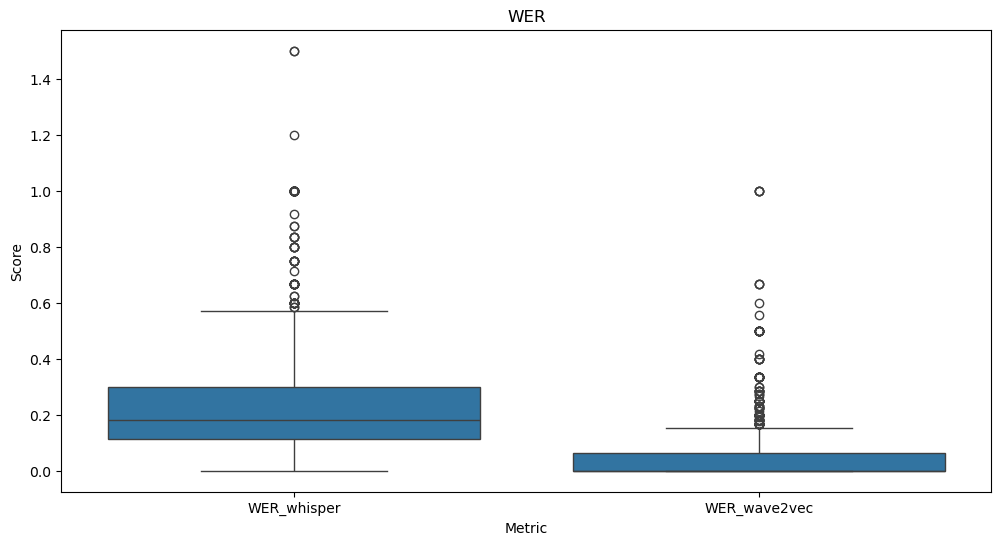

In [434]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Metric', y='Score', data = df_long)
plt.title('WER')
plt.show()